In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.decomposition import SparseCoder
%matplotlib inline

pd.set_option('display.max_columns', 120)

## in this notebook we assume `y` is a quotient differential between two consecutive timesteps

In [3]:
with pd.HDFStore("/Users/rlx/datasets/twosigma/train.h5", "r") as train:
    df = train.get("train")
df.shape

(1710756, 111)

In [4]:
def diffs2signal(s):
    r = np.ones(len(s)+1)
    for i in range(len(s)):
        r[i+1] = r[i]*(1+s[i])
    r = r[1:]
    return r

def signal2diffs(s):
    return np.array([1]+list(s[1:]/s[:-1]))-1

In [5]:
df.fillna(0, inplace=True)

In [6]:
gf = df.copy()#iloc[:4000]

In [7]:
gf = gf.set_index(['id', "timestamp"]).reindex()

In [8]:
def correlations(gf, asset):
    cols = np.array([i for i in gf.ix[asset].columns if i!="y"])
    y   = gf.ix[asset]["y"].values
    ys  = diffs2signal(y)
    r = []    
    for col in cols:
        v   = gf.ix[asset][col]
        r.append(np.corrcoef(v, ys)[0,1])
    r = np.nan_to_num(r)
    return cols, ys,r

In [9]:
def plot_asset_correlations(gf, asset):
    cols, ys, r = correlations(gf, asset)
    plt.figure(figsize=(20,3))
    plt.scatter(range(len(r)), r, color="blue")
    plt.xlim(-1,len(r)+1)
    plt.axhline(0, color="gray", lw=2,alpha=1.)
    plt.grid()
    plt.xticks(range(len(r)), cols, rotation='vertical');
    plt.ylim(-1.1,1.1);
    plt.title("correlations for reconstructed asset "+str(asset)+" with "\
              +str(len(gf.ix[asset]))+" timestamps, "\
              +"from timestamp "+str(np.min(gf.ix[asset].index.values))\
              +" to "+str(np.max(gf.ix[asset].index.values)))
    maxfeat = cols[np.argmax(r)]

    from sklearn.preprocessing import MinMaxScaler


    sfeats = cols[np.argsort(-r)]
    r = r[np.argsort(-r)]
    plt.figure(figsize=(20,6))

    for i in range(3):
        plt.subplot(211)
        vs = gf.ix[asset][sfeats[i]]
        fs = MinMaxScaler(feature_range=(np.min(ys), np.max(ys))).fit_transform(vs.reshape(-1,1))[:,0]
        plt.plot(fs, label="%.3f"%r[i]+" "+sfeats[i], alpha=.5)

        plt.subplot(212)
        vs = -gf.ix[asset][sfeats[-(i+1)]]
        fs = MinMaxScaler(feature_range=(np.min(ys), np.max(ys))).fit_transform(vs.reshape(-1,1))[:,0]
        plt.plot(fs, label="%.3f"%r[-(i+1)]+" "+sfeats[-(i+1)], alpha=.5)

    plt.subplot(211)
    plt.title("features with most positive correlation for asset "+str(asset))
    plt.plot(ys, label="signal y", lw=3, color="black",alpha=.5)
    plt.legend()
    plt.subplot(212)
    plt.title("features with most negative correlation for asset "+str(asset)+" ($showing$ $negative$ $signal$)")
    plt.plot(ys, label="signal y", lw=3, color="black", alpha=.5)
    plt.legend()



## plot some correlations to reconstructed signal

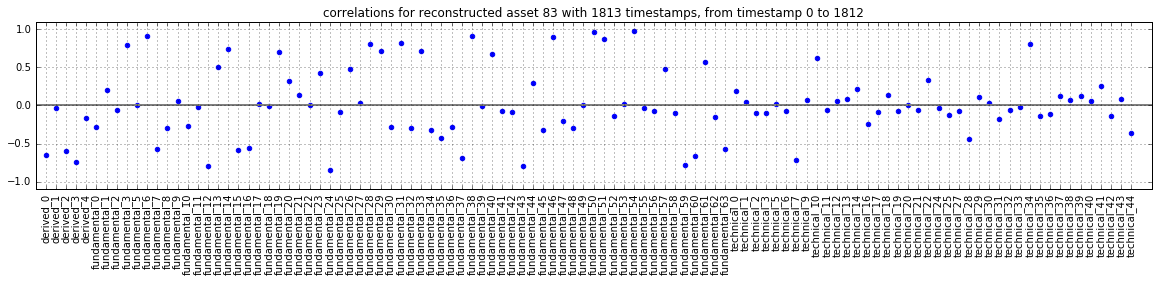

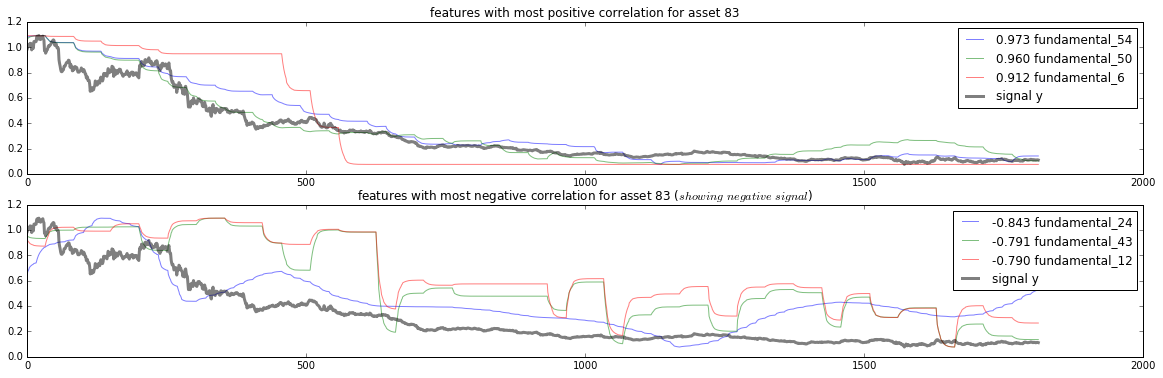

In [10]:
plot_asset_correlations(gf, 83)    

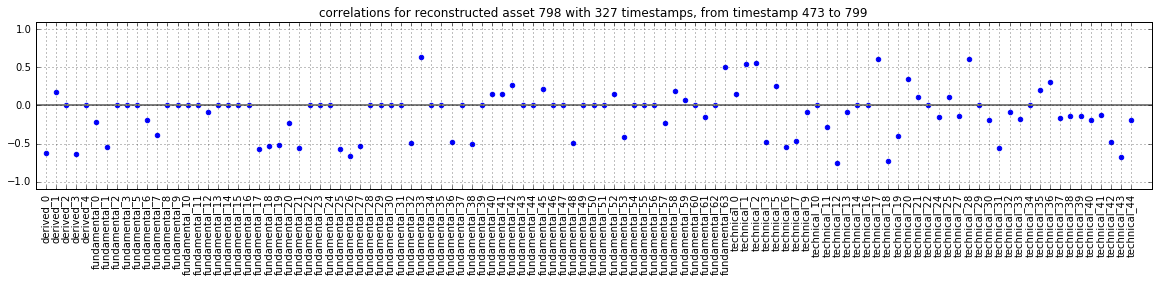

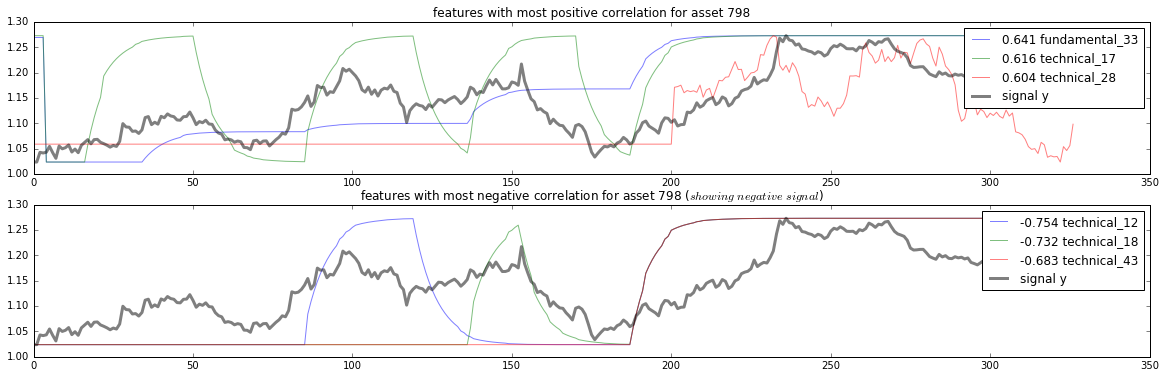

In [11]:
asset=gf.index.levels[0].values[np.random.randint(len(gf.index.levels[0].values))]
plot_asset_correlations(gf, asset)

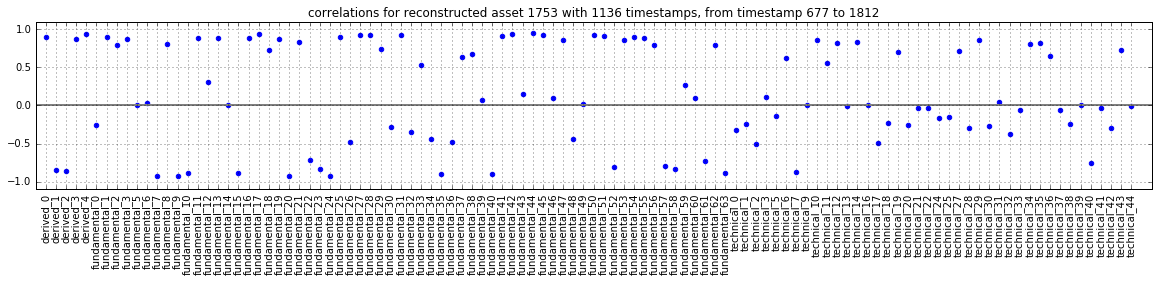

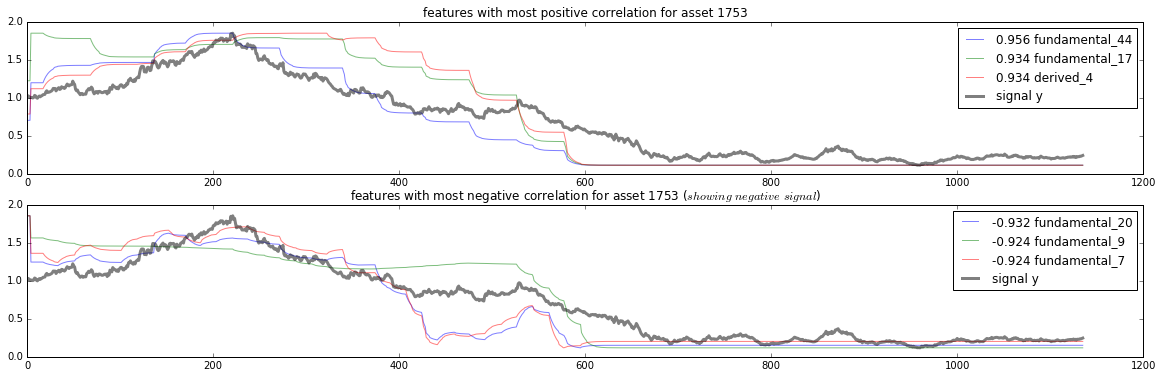

In [12]:
plot_asset_correlations(gf, 1753)

## build correlation matrix between some assets and all features

- positive correlations darker, negative lighter
- features and assets sorted by avg correlation (i.e. the matrix is darker at top right and lighter at bottom left)

In [13]:
assets = gf.index.levels[0].values

In [14]:
assets = sorted(gf.index.levels[0].values)[:200]
ra = []
for asset in assets:
    cols, _,r = correlations(gf,asset)
    ra.append(r)
    print asset, 

0 6 7 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26 27 30 31 32 33 38 39 40 41 43 44 46 47 48 49 52 54 55 56 58 59 60 62 63 64 65 66 68 69 70 72 76 77 79 80 81 82 83 85 87 88 90 91 93 95 97 98 99 100 101 102 103 104 105 106 108 111 112 113 115 118 119 121 122 124 126 127 128 129 130 131 132 133 134 137 140 141 142 149 150 151 152 154 156 158 159 160 161 163 166 169 170 171 172 173 174 175 176 177 178 179 181 183 184 185 186 187 188 191 195 198 199 203 205 206 208 212 214 215 216 217 218 219 220 221 222 223 224 225 226 227 229 231 232 233 235 239 240 241 242 244 245 248 249 252 253 255 256 257 258 259 261 262 264 265 266 268 269 270 271 273 274 275 277 278 279 280 281 284 285 286 287 288 289 290 294 295 296 297 298 300


In [15]:
assets = sorted(gf.index.levels[0].values)[:200]
corrs = pd.DataFrame(ra, columns=cols)
corrs.index = assets

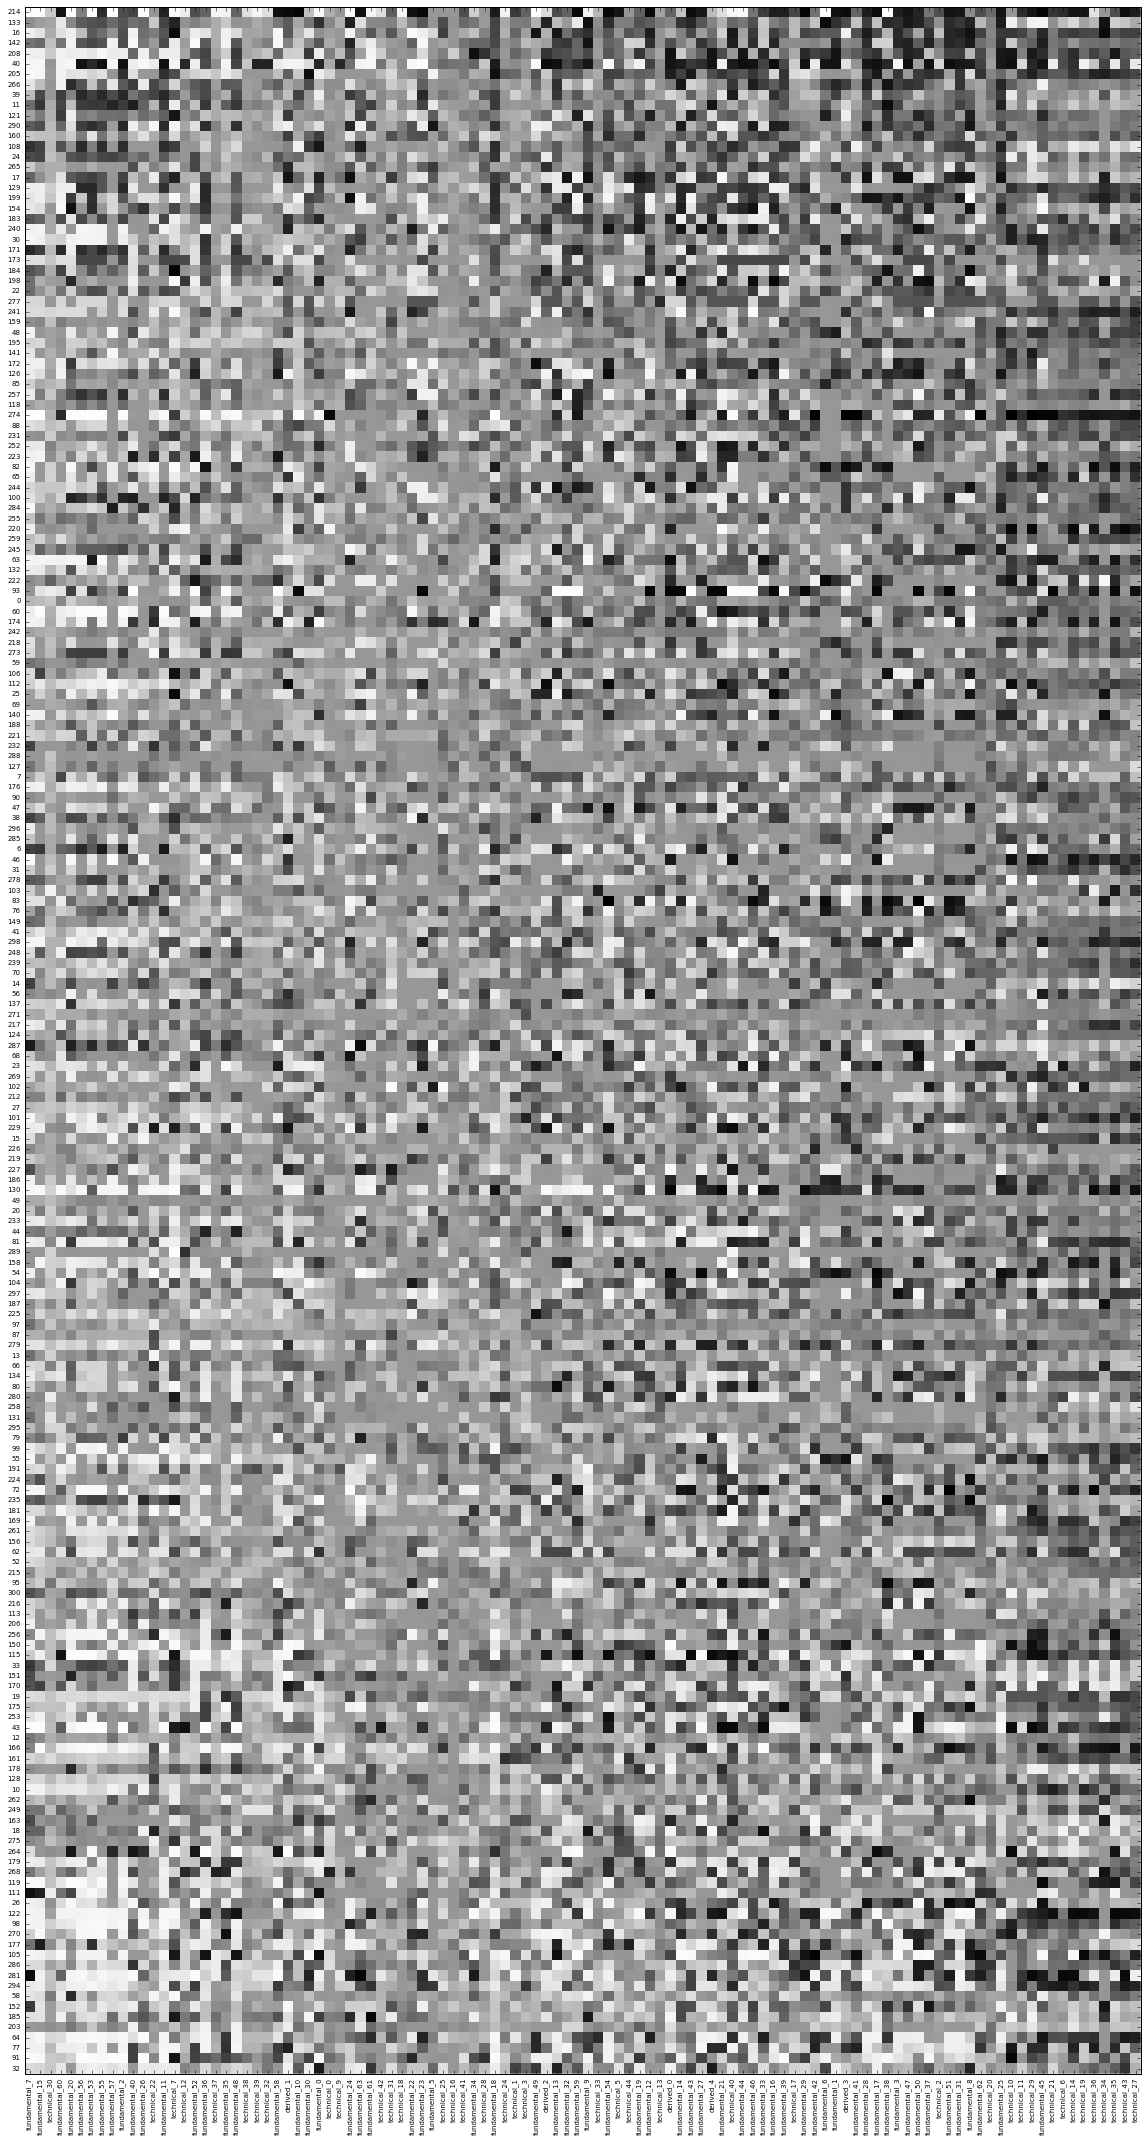

In [16]:
plt.figure(figsize=(20,int(len(assets)*1.4)))
scols  = corrs.columns[np.argsort(corrs.mean().values)]
sindex = corrs.index[np.argsort((corrs.mean(axis=1).values))]
plt.imshow(corrs.ix[sindex][scols].values, cmap=plt.cm.Greys, interpolation="none", origin="lower")
plt.xticks(range(len(corrs.columns)), scols, rotation="vertical", fontsize=7);
plt.yticks(range(len(corrs)), sindex, fontsize=7);

In [17]:
def plot_assets_features(gf, assets, feats):
    rows, cols = len(assets), len(feats)
    plt.figure(figsize=(cols*4, rows*3))
    c=1
    for asset in assets:
        y = gf.ix[asset].y.values
        ys = diffs2signal(y)
        for feat in feats:
            plt.subplot(rows, cols, c)
            plt.plot(ys, lw=2, color="black", alpha=0.7)
            fs = gf.ix[asset][feat].values
            corr = np.corrcoef(fs, ys)[0,1]
            fs = -fs if corr<0 else fs
            fs = MinMaxScaler(feature_range=(np.min(ys), np.max(ys))).fit_transform(fs.reshape(-1,1))[:,0]
            plt.plot(fs, color="red" if corr<0 else "blue")
            plt.title("id "+str(asset)+", "+feat+ ", corr %.2f"%corr)
            c+=1
            plt.xticks([]);
            plt.yticks([]);

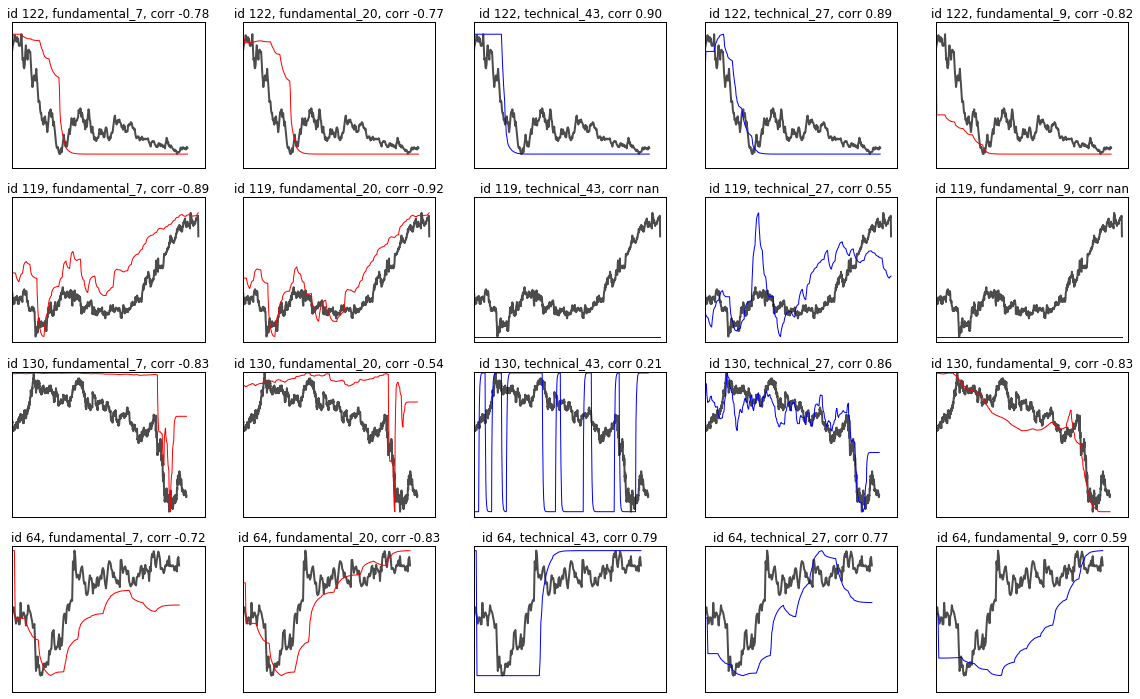

In [18]:
from sklearn.preprocessing import MinMaxScaler
assets = [122 ,119, 130, 64]
feats  = ["fundamental_7", "fundamental_20", "technical_43", "technical_27", "fundamental_9"]
plot_assets_features(gf, assets, feats)

In [180]:
idxs = corrs.mean().sort_values().index
print "top5 cols with largest positive correlation"
print idxs[-5:].values
print "\ntop5 cols with largest negative correlation"
print idxs[:5].values


top5 cols with largest positive correlation
[u'technical_36' u'technical_34' u'technical_35' u'technical_43'
 u'technical_27']

top5 cols with largest negative correlation
[u'fundamental_7' u'fundamental_15' u'technical_30' u'fundamental_60'
 u'fundamental_20']


In [29]:
idxs = corrs.mean().sort_values().index
bcols = list(idxs[:40])#+list(idxs[-5:])
bcols = list(idxs[-20:])
bcols


[u'technical_2',
 u'fundamental_51',
 u'fundamental_31',
 u'fundamental_8',
 u'fundamental_62',
 u'technical_20',
 u'fundamental_25',
 u'technical_10',
 u'technical_11',
 u'technical_29',
 u'fundamental_45',
 u'technical_21',
 u'technical_6',
 u'technical_14',
 u'technical_19',
 u'technical_36',
 u'technical_34',
 u'technical_35',
 u'technical_43',
 u'technical_27']

## build test/train dataset by splitting in half

In [54]:
trix = np.arange(len(df)/2)
tsix = np.arange(len(df)/2,len(df))
df_ts = df.iloc[tsix].copy()
df_ts.fillna(0, inplace=True)
df_tr = df.iloc[trix].copy()
df_tr.fillna(0, inplace=True)

In [55]:
gf_tr = df_tr.copy()
gf_ts = df_ts.copy()
gf_tr = gf_tr.set_index(['id', "timestamp"]).reindex()
gf_ts = gf_ts.set_index(['id', "timestamp"]).reindex()

In [56]:
for i in gf_tr.index.levels[0].values:
    gf_tr.ix[i,"y_recr"] = diffs2signal(gf_tr.ix[i].y.values)    
for i in gf_ts.index.levels[0].values:
    gf_ts.ix[i,"y_recr"] = diffs2signal(gf_ts.ix[i].y.values)    

### train model

In [57]:
cols = ["technical_20", "technical_43"]
cols = bcols
x_train=gf_tr[cols].values
y = gf_tr.y_recr.values

lr_model = LinearRegression()
lr_model = RandomForestRegressor()

lr_model = Pipeline([('anova', SelectKBest(f_regression, k=5)), ('regr', LinearRegression())])
lr_model = Pipeline([('anova', PCA(n_components=10)), ('regr', LinearRegression())])

lr_model.fit(x_train, y)

Pipeline(steps=[('anova', PCA(copy=True, n_components=10, whiten=False)), ('regr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

### test model with a single asset. we need to continuously reconstruct

In [183]:
last_y = {}
for i in np.unique(gf_tr.index.levels[0]):
    last_y[i] = gf_tr.ix[0].y_recr.values[-1]


In [184]:
assets = np.unique(gf_ts.index.levels[0])
asset = assets[np.random.randint(len(assets))]
print asset
ts_ofeats = gf_ts.ix[asset]
tr_ofeats = gf_tr.ix[asset]

175


In [185]:
ts_preds = np.array([lr_model.predict(ts_ofeats.iloc[i][cols].values.reshape(1,-1))[0] for i in range(len(ts_ofeats))])
tr_preds = np.array([lr_model.predict(tr_ofeats.iloc[i][cols].values.reshape(1,-1))[0] for i in range(len(tr_ofeats))])


In [186]:
r2_score(tr_ofeats.y_recr.values, tr_preds), r2_score(tr_ofeats.y.values, signal2diffs(tr_preds))


(-3.4435099225037353, -0.18938824297315904)

### test with all assets

In [112]:
from sklearn.metrics import r2_score
asset = assets[np.random.randint(len(assets))]
all_test_r2y = {}
all_test_r2yr = {}
for asset in assets:
    ts_ofeats = gf_ts.ix[asset]
    ts_preds = np.array([lr_model.predict(ts_ofeats.iloc[i][cols].values.reshape(1,-1))[0] for i in range(len(ts_ofeats))])
    test_r2yr, test_r2y = r2_score(ts_ofeats.y_recr.values, ts_preds), r2_score(ts_ofeats.y.values, signal2diffs(ts_preds))
    all_test_r2y[asset] = test_r2y
    all_test_r2yr[asset] = test_r2yr
    if asset in gf_tr.index.levels[0]:
        tr_ofeats = gf_tr.ix[asset]
        tr_preds = np.array([lr_model.predict(tr_ofeats.iloc[i][cols].values.reshape(1,-1))[0] for i in range(len(tr_ofeats))])
        train_r2yr, train_r2y = r2_score(tr_ofeats.y_recr.values, tr_preds), r2_score(tr_ofeats.y.values, signal2diffs(tr_preds))
    else:
        train_r2yr, train_r2y = np.nan, np.nan 
    print "%5d"%asset,"  test  y_recr %.2f, y %.2f"%(test_r2yr, test_r2y)+"   train y_recr %.2f, y %.2f"%(train_r2yr, train_r2y)


    0   test  y_recr -8.63, y -0.17   train y_recr -0.95, y -0.07
    6   test  y_recr -3.96, y -0.12   train y_recr nan, y nan
    7   test  y_recr -0.29, y -0.01   train y_recr 0.02, y -0.16
   11   test  y_recr -2.73, y -0.28   train y_recr -9.69, y -0.16
   12   test  y_recr -14.05, y -0.17   train y_recr -1.26, y -0.21
   13   test  y_recr -5.26, y -0.00   train y_recr -38.77, y -0.04
   14   test  y_recr -7.11, y -0.63   train y_recr nan, y nan
   15   test  y_recr -0.22, y -0.14   train y_recr -11.88, y -0.13
   16   test  y_recr -2.11, y -0.26   train y_recr -0.16, y -0.03
   17   test  y_recr -0.82, y -0.08   train y_recr nan, y nan
   18   test  y_recr -24.89, y -0.07   train y_recr nan, y nan
   19   test  y_recr -0.97, y -0.17   train y_recr nan, y nan
   20   test  y_recr -6.12, y -0.07   train y_recr -8.92, y -0.06
   22   test  y_recr -3.88, y -0.22   train y_recr -3.57, y -0.18
   23   test  y_recr -2.45, y -0.43   train y_recr nan, y nan
   24   test  y_recr -3.23, y -

### top 10 assets

In [189]:
assets = np.array(all_test_r2y.keys())[np.argsort(all_test_r2y.values())[-10:]]
assets

array([1760, 1497, 2134, 2000,  926,  799,  667, 1078,  297, 1348])

### view prediction

In [191]:
asset = 2000
print all_test_r2y[asset], all_test_r2yr[asset]

0.000880754133569 -2.48335566306


In [192]:
ts_ofeats = gf_ts.ix[asset]
ts_preds = np.array([lr_model.predict(ts_ofeats.iloc[i][cols].values.reshape(1,-1))[0] for i in range(len(ts_ofeats))])
tr_ofeats = gf_tr.ix[asset]
tr_preds = np.array([lr_model.predict(tr_ofeats.iloc[i][cols].values.reshape(1,-1))[0] for i in range(len(tr_ofeats))])


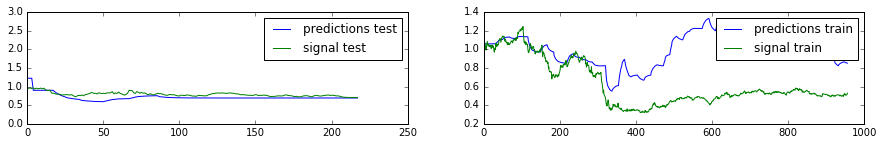

In [165]:
plt.figure(figsize=(15,2))
plt.subplot(121)
plt.plot(ts_preds, label="predictions test")
plt.plot(ts_ofeats.y_recr.values, label="signal test")
plt.legend()
plt.ylim(0,3)
plt.subplot(122)
plt.plot(tr_preds, label="predictions train")
plt.plot(tr_ofeats.y_recr.values, label="signal train")
plt.legend()